In [1]:
import math
import os
import time
import random
import pickle

from torchvision.datasets import CocoCaptions
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn.init as init
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [2]:
# import numpy as np
# lr = 1e-2
# epochs = 300
# eps = []
# lrs = []
# for i in range(epochs):
#     eps.append(i)
#     lrs.append(lr)
#     lr *= 0.9
#
# fig, ax = plt.subplots()
# ax.plot(eps, lrs)
# ax.set_yscale('log')
# plt.show()

In [3]:
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

In [80]:
class CaptionPreprocessor:
    def __init__(self, captions, tokenizer, max_caption_length=20):
        self.tokenizer = tokenizer
        self.max_caption_length = max_caption_length
        self.total_caption_length = 0
        self.total_squared_caption_length = 0

        if not self.tokenizer.bos_token:
            self.tokenizer.bos_token = '[CLS]'
        if not self.tokenizer.eos_token:
            self.tokenizer.eos_token = '[SEP]'

        self.captions_tokenized = self.tokenize_captions(captions)

    def preprocess(self, caption):
        tokens = [self.tokenizer.bos_token] + self.tokenizer.tokenize(caption) + [self.tokenizer.eos_token]
        caption_indices = self.tokenizer.convert_tokens_to_ids(tokens)
        caption_length = len(caption_indices)

        if caption_length < self.max_caption_length:
            caption_indices += [self.tokenizer.pad_token_id] * (self.max_caption_length - caption_length)

        self.total_caption_length += caption_length
        self.total_squared_caption_length += caption_length**2

        return caption_indices[:self.max_caption_length]

    def tokenize_captions(self, captions):
        return [self.preprocess(caption) for caption in captions]

    def get_average_caption_length(self):
        return self.total_caption_length / len(self.captions_tokenized)

    def get_caption_length_standard_deviation(self):
        mean = self.get_average_caption_length()
        variance = (self.total_squared_caption_length / len(self.captions_tokenized)) - mean**2
        std_dev = math.sqrt(max(0, variance))
        return std_dev

In [81]:
class CustomCocoDataset(Dataset):
    def __init__(self, coco_dataset, caption_preprocessor, num_captions=5):
        self.coco_dataset = coco_dataset
        self.caption_preprocessor = caption_preprocessor
        self.num_captions = num_captions

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, caption_list = self.coco_dataset[idx]

        # hits when using test dataset which doesn't have captions
        if not caption_list:
            return img, None

        selected_caption = random.choice(caption_list[:self.num_captions])
        preprocessed_caption = torch.tensor(self.caption_preprocessor.preprocess(selected_caption))
        return img, preprocessed_caption

In [82]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        init.xavier_uniform_(self.proj.weight)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(patch_size, in_channels, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, (224 // patch_size) * (224 // patch_size) + 1, embed_dim))

        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])

        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.positional_encoding[:, :-1]
        for layer in self.transformer_layers:
            x = layer(x)

        return x

In [83]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=20):
        super().__init__()
        self.encoding = nn.Parameter(torch.zeros(1, max_len, d_model), requires_grad=False)

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, :, 0::2] = torch.sin(pos * div_term)
        self.encoding[:, :, 1::2] = torch.cos(pos * div_term)

    def forward(self, x):
        x = x + self.encoding[:, :x.size(1), :]
        return x


class TransformerCaptionDecoder(nn.Module):
    def __init__(self, auto_model, d_model, num_layers, num_heads, mlp_dim, max_len=20):
        super().__init__()

        self.auto_model = auto_model
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, self.auto_model.config.vocab_size)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, captions, memory):
        captions = self.auto_model.embeddings(captions)
        captions = self.positional_encoding(captions)

        for layer in self.transformer_layers:
            captions = layer(captions, memory)

        logits = self.output_layer(captions)
        return logits

In [84]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, image_encoder, caption_decoder):
        super(ImageCaptioningModel, self).__init__()
        self.image_encoder = image_encoder
        self.caption_decoder = caption_decoder
        self.start_token_index = caption_decoder.auto_model.config.bos_token_id or 0
        self.embedding_size = caption_decoder.auto_model.config.hidden_size
        self.image_feature_linear = nn.Linear(768, self.embedding_size)

    def forward(self, images, captions):
        image_features = self.image_encoder(images)
        num_patches = (224 // 16) * (224 // 16)
        # image_features_flattened = image_features.permute(1, 0, 2).reshape(-1, num_patches, self.embedding_size)

        start_token_tensor = torch.tensor([self.start_token_index], dtype=torch.long, device=images.device)
        start_token_embeddings = self.caption_decoder.auto_model.embeddings(start_token_tensor).repeat(image_features.shape[0], 1, 1) # getting start token embedding and repeating it for batch size
        image_features_summed = image_features.sum(dim=1).unsqueeze(1)
        image_features_summed = self.image_feature_linear(image_features_summed)
        memory = torch.cat([start_token_embeddings, image_features_summed], dim=1) # Concatenate the start token embeddings with the flattened image features

        memory = memory.transpose(0, 1)
        captions = captions.transpose(0, 1)

        output = self.caption_decoder(captions, memory)
        return output

    # used for inference with test dataset
    def sample(self, images, max_len=20):
        with torch.no_grad():
            image_features = self.image_encoder(images)
            num_patches = (224 // 16) * (224 // 16)

            start_token_tensor = torch.tensor([self.start_token_index], dtype=torch.long, device=images.device)
            start_token_embeddings = self.caption_decoder.auto_model.embeddings(start_token_tensor).repeat(image_features.shape[0], 1, 1)
            image_features_summed = image_features.sum(dim=1).unsqueeze(1)
            image_features_summed = self.image_feature_linear(image_features_summed)
            memory = torch.cat([start_token_embeddings, image_features_summed], dim=1)
            memory = memory.transpose(0, 1)

            input_ids = start_token_tensor.unsqueeze(1).repeat(1, image_features.shape[0]).transpose(0, 1)

            for _ in range(max_len - 1):
                captions = torch.full((1, 1), self.start_token_index, dtype=torch.long, device=images.device)
                captions = self.caption_decoder.positional_encoding(captions)

                for layer in self.caption_decoder.transformer_layers:
                    captions = layer(captions, memory)

                logits = self.caption_decoder.output_layer(captions)
                next_token_logits = logits[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
                input_ids = torch.cat([input_ids, next_token], dim=-1)

            return input_ids



In [85]:
def train_one_epoch(model,
                    dataloader,
                    criterion,
                    optimizer,
                    scheduler,
                    device,
                    epoch,
                    num_epochs,
                    avg_every,
                    learning_rates):
    model.train()
    train_loss = 0
    last_x_losses = []
    for i, (images, captions) in enumerate(tqdm(dataloader, desc='Training')):
    # for i, (images, captions) in enumerate(dataloader):
        images = images.to(device)
        captions_input = captions[:, :-1].to(device)
        captions_target = captions[:, 1:].to(device)

        optimizer.zero_grad()
        output = model(images, captions_input)

        loss = criterion(output.reshape(-1, 30522), captions_target.view(-1))
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        learning_rates.append(optimizer.param_groups[0]['lr'])
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        last_x_losses.append(loss.item())

        if i % avg_every == 0 and i != 0:
            avg_loss = sum(last_x_losses) / len(last_x_losses)
            print(f'Epoch: {epoch+1}/{num_epochs}, Iteration: {i}, Loss (last {avg_every} iterations): {avg_loss:.4f}')
    return train_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc='Validating'):
        # for images, captions in dataloader:
            image = images.to(device)
            captions_input = captions[:, :-1].to(device)
            captions_target = captions[:, 1:].to(device)

            output = model(images, captions_input)
            loss = criterion(output.reshape(-1, 30522), captions_target.view(-1))

            val_loss += loss.item()
    return val_loss / len(dataloader)

In [86]:
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self.learning_rate()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def learning_rate(self):
        arg1 = self.current_step ** -0.5
        arg2 = min(self.current_step * self.warmup_steps ** -1.5, 1)
        return (self.d_model ** -0.5) * min(arg1, arg2)

In [87]:
def plot_and_save(train_losses, val_losses, learning_rates):
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(train_losses, label='Train Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_title('Training and Validation Losses', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('losses.png')

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(learning_rates, label='Learning Rate')
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Learning Rate', fontsize=14)
    ax.set_title('Learning Rate Schedule', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid()
    ax.legend(fontsize=12)
    fig.savefig('learning_rates.png')


In [88]:
def save_lists_to_file(file_path, train_losses, val_losses, learning_rates):
    data = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
    }
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)


def load_lists_from_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data['train_losses'], data['val_losses'], data['learning_rates']

In [89]:
# Needed when running inference on laptop
def adjust_state_dict_keys(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    return new_state_dict

In [90]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
tokenizer_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

train_dataset = CocoCaptions(root='./coco/images',
                       annFile='./coco/annotations/captions_train2014.json',
                       transform=image_transform)
val_dataset = CocoCaptions(root='./coco/images',
                           annFile='./coco/annotations/captions_val2014.json',
                           transform=image_transform)
train_captions = [entry['caption'] for entry in train_dataset.coco.anns.values()]
val_captions = [entry['caption'] for entry in val_dataset.coco.anns.values()]

caption_preprocessor = CaptionPreprocessor(train_captions + val_captions, tokenizer)

max_caption_length_train = max([len(caption.split()) for caption in train_captions])
max_caption_length_val = max([len(caption.split()) for caption in val_captions])
max_caption_length = max(max_caption_length_train, max_caption_length_val)

print(max_caption_length_train, max_caption_length_val, max_caption_length)
print('Maximum caption length (without <start>, <end>, and <pad> tokens):', max_caption_length)

average_caption_length = caption_preprocessor.get_average_caption_length()
std_dev_caption_length = caption_preprocessor.get_caption_length_standard_deviation()

print('Average caption length:', average_caption_length)
print('Standard deviation of caption length:', std_dev_caption_length)

custom_train_dataset = CustomCocoDataset(train_dataset, caption_preprocessor, num_captions=5)
custom_val_dataset = CustomCocoDataset(val_dataset, caption_preprocessor, num_captions=5)

batch_size = 512
train_data_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_data_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...


Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


index created!
49 50 50
Maximum caption length (without <start>, <end>, and <pad> tokens): 50
Average caption length: 13.811654968569979
Standard deviation of caption length: 2.810517514781474


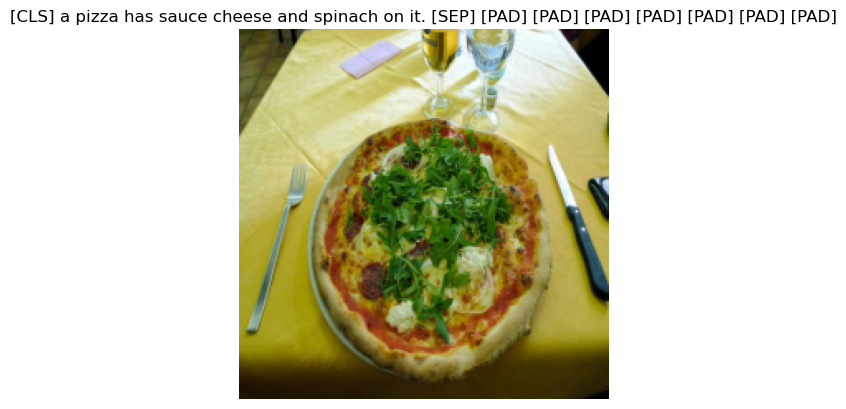

In [92]:
import numpy as np

def display_random_sample(dataset, tokenizer):
    random_idx = np.random.randint(0, len(dataset))
    image, caption = dataset[random_idx]
    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    caption_text = tokenizer.decode(caption.numpy(), skip_special_tokens=False)

    plt.imshow(image)
    plt.axis('off')
    plt.title(caption_text)
    plt.show()

# Display a random sample from the training dataset
# display_random_sample(custom_train_dataset, tokenizer)


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_encoder = VisionTransformer(in_channels=3,
                                  patch_size=16,
                                  embed_dim=768,
                                  num_layers=4,
                                  num_heads=8,
                                  mlp_dim=256,
                                  num_classes=768).to(device)

auto_model = AutoModel.from_pretrained(tokenizer_name).to(device)
caption_decoder = TransformerCaptionDecoder(auto_model=auto_model,
                                            d_model=768,
                                            num_layers=4,
                                            num_heads=8,
                                            mlp_dim=256).to(device)

model = ImageCaptioningModel(image_encoder, caption_decoder).to(device)

useTwoGPUs = True
if torch.cuda.device_count() > 1 and useTwoGPUs:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

num_epochs = 100

total_samples = len(train_data_loader.dataset)
batch_size = train_data_loader.batch_size
max_iterations = math.ceil(total_samples / batch_size)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0)  #, weight_decay=1e-5)

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.67, patience=2, verbose=True)
scheduler = NoamScheduler(optimizer, d_model=768, warmup_steps=4000)
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=int(num_epochs / 5), eta_min=1e-6)

best_val_loss = float('inf')

train_losses = []
val_losses = []
learning_rates = []

load_best_model = False
load_final = False
best_model_path = 'best_model_monday.pt'
save_lists_path = 'best_data_monday.pkl'
if load_best_model and os.path.exists(best_model_path):
    if torch.cuda.is_available():
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        checkpoint = torch.load(best_model_path, map_location=torch.device('cpu'))
        adjusted_state_dict = adjust_state_dict_keys(checkpoint['model_state_dict'])
        model.load_state_dict(adjusted_state_dict)

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.__dict__.update(checkpoint['scheduler_state_dict'])
    best_val_loss = checkpoint['best_val_loss']
    train_losses, val_losses, learning_rates = load_lists_from_file(save_lists_path)
    start_epoch = len(train_losses)
    if start_epoch >= num_epochs:
        raise ValueError('Number of epochs to train on is too small')
    training_range = range(start_epoch, num_epochs)
    print(len(train_losses))
    print('Loaded best saved model...')
    print(f'Validation loss of the loaded model: {best_val_loss:.4f}')
else:
    training_range = range(num_epochs)


cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: Error(s) in loading state_dict for ImageCaptioningModel:
	size mismatch for caption_decoder.positional_encoding.encoding: copying a param with shape torch.Size([1, 128, 768]) from checkpoint, the shape in current model is torch.Size([1, 20, 768]).

In [ ]:
print('**********STARTING TRAINING**********')
training_start = time.time()
for epoch in training_range:
    epoch_start = time.time()

    print(f'Total samples: {total_samples}, Batch size: {batch_size}, Maximum iterations: {max_iterations}')

    avg_every = 20
    old_lr = optimizer.param_groups[0]['lr']

    train_loss = train_one_epoch(model, train_data_loader, criterion, optimizer, scheduler, device, epoch, num_epochs, avg_every, learning_rates)
    print(f'TRAINING LOSS FOR EPOCH {epoch + 1}: {train_loss:.4f}')

    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f'****LR changed from {old_lr} ==> {new_lr}****')

    val_loss = evaluate(model, val_data_loader, criterion, device)
    print(f'VALIDATION LOSS FOR EPOCH {epoch + 1}: {val_loss:.4f}')
    print(f'CURRENT BEST VALIDATION LOSS: {best_val_loss:.4f}')

    epoch_end = time.time()
    print(f'Epoch {epoch+1}/{num_epochs} total time: {epoch_end - epoch_start}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        if load_final:
            save_name = 'best_loss_model_noam_restart.pt'
            save_lists_path = 'training_data_noam_restart.pkl'
        else:
            save_name = best_model_path

        best_val_loss = val_loss

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.__dict__,
            'best_val_loss': best_val_loss,
        }, save_name)
        save_lists_to_file(save_lists_path, train_losses, val_losses, learning_rates)
        print(f'**********NEW BEST MODEL SAVED @ VAL: {best_val_loss:.4f}**********')

    if epoch == num_epochs - 1:
        final_val_loss = val_loss
        final_save_name = 'final_model_monday.pt'
        final_save_lists = 'final_data_monday.pkl'

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.__dict__,
            'best_val_loss': final_val_loss,
        }, final_save_name)
        save_lists_to_file(final_save_lists, train_losses, val_losses, learning_rates)

training_end = time.time()
print(f'Total training time: {training_end - training_start}')



plot_and_save(train_losses, val_losses, learning_rates)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
#
# test_dataset = CocoCaptions(root='./coco/images',
#                             annFile='./coco/annotations/image_info_test2014.json',
#                             transform=image_transform)
# custom_test_dataset = CustomCocoDataset(test_dataset, caption_preprocessor, num_captions=5)

In [ ]:
# def generate_caption(model, image, tokenizer, device, max_len=20):
#     model.eval()
#     with torch.no_grad():
#         image = image.unsqueeze(0).to(device)
#         generated_caption = model.sample(image, max_len)
#         decoded_caption = tokenizer.decode(generated_caption.squeeze().tolist(), skip_special_tokens=True)
#     return decoded_caption

In [ ]:
# random_idx = random.randint(0, len(custom_test_dataset) - 1)
# image, _ = custom_test_dataset[random_idx]
#
# generated_caption = generate_caption(model, image, tokenizer, device)
# print('Generated caption:', generated_caption)